In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import math
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta, date
from sklearn.metrics import mean_squared_error

#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,concatenate,Dense,Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Flatten, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [9]:
#status_df = pd.read_csv("dataset/status.csv")
#station_df = pd.read_csv("dataset/station.csv")
leave_df = pd.read_csv("dataset/leave_data.csv")
arrive_df = pd.read_csv("dataset/arrive_data.csv")
#status_df.head()

In [3]:
main_df = pd.read_csv("main.csv")
main_df = main_df.drop('Unnamed: 0', axis=1)

In [70]:
#stationの特徴量エンジニアリング

In [71]:
city_df = pd.DataFrame()
city_df['city'] = ['city1', 'city2', 'city3', 'city4', 'city5']

In [72]:
city_df['name'] = ['SanJose', 'SanFrancisco', 'RedwoodCity', 'MountainView', 'MenloPark']
city_df['popu_density'] = ['2200', '7022', '1494', '2263', '5203']

In [73]:
station_df

,station_id,lat,long,dock_count,city,installation_date
0,0,37.32973,-121.90178,27,city1,8/6/2013
1,1,37.33070,-121.88898,15,city1,8/5/2013
2,2,37.33399,-121.89490,11,city1,8/6/2013
3,3,37.33141,-121.89320,19,city1,8/5/2013
4,4,37.33672,-121.89407,15,city1,8/7/2013
...,...,...,...,...,...,...
65,65,37.78963,-122.40081,27,city2,8/25/2013
66,66,37.35260,-121.90573,15,city1,12/31/2013
67,67,37.79854,-122.40086,15,city2,1/22/2014
68,68,37.49127,-122.23623,15,city3,2/20/2014


In [74]:
for i, date in enumerate(station_df['installation_date']):
    date_list = date.split('/')
    station_df['installation_date'][i] = datetime.date(int(date_list[2]), int(date_list[0]), int(date_list[1]))
    
station_df.head()

,station_id,lat,long,dock_count,city,installation_date
0,0,37.32973,-121.90178,27,city1,2013-08-06
1,1,37.33070,-121.88898,15,city1,2013-08-05
2,2,37.33399,-121.89490,11,city1,2013-08-06
3,3,37.33141,-121.89320,19,city1,2013-08-05
4,4,37.33672,-121.89407,15,city1,2013-08-07


In [75]:
city_df

,city,name,popu_density
0,city1,SanJose,2200
1,city2,SanFrancisco,7022
2,city3,RedwoodCity,1494
3,city4,MountainView,2263
4,city5,MenloPark,5203


In [76]:
station_df = pd.merge(station_df, city_df[['popu_density', 'city']], on='city')

In [77]:
station_df

,station_id,lat,long,dock_count,city,installation_date,popu_density
0,0,37.32973,-121.90178,27,city1,2013-08-06,2200
1,1,37.33070,-121.88898,15,city1,2013-08-05,2200
2,2,37.33399,-121.89490,11,city1,2013-08-06,2200
3,3,37.33141,-121.89320,19,city1,2013-08-05,2200
4,4,37.33672,-121.89407,15,city1,2013-08-07,2200
...,...,...,...,...,...,...,...
65,62,37.79414,-122.39443,23,city2,2013-08-25,7022
66,63,37.79130,-122.39905,19,city2,2013-08-25,7022
67,64,37.78630,-122.40497,19,city2,2013-08-25,7022
68,65,37.78963,-122.40081,27,city2,2013-08-25,7022


In [78]:
#駅との距離


In [79]:
#曜日を追加するための関数を定義
def get_weekday_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

#year, month, dayを結合してdatetime型に変換
status_df["date"] = status_df["year"].astype(str) + status_df["month"].astype(str).str.zfill(2) + status_df["day"].astype(str).str.zfill(2)
status_df["date"] = pd.to_datetime(status_df["date"])
#dateから曜日情報を取得
status_df["weekday"] = status_df["date"].apply(get_weekday_jp)
status_df.head(10)

,id,year,month,day,hour,station_id,bikes_available,predict,date,weekday
0,0,2013,9,1,0,0,11.0,0,2013-09-01,日曜日
1,1,2013,9,1,1,0,11.0,0,2013-09-01,日曜日
2,2,2013,9,1,2,0,11.0,0,2013-09-01,日曜日
3,3,2013,9,1,3,0,11.0,0,2013-09-01,日曜日
4,4,2013,9,1,4,0,11.0,0,2013-09-01,日曜日
5,5,2013,9,1,5,0,11.0,0,2013-09-01,日曜日
6,6,2013,9,1,6,0,11.0,0,2013-09-01,日曜日
7,7,2013,9,1,7,0,11.0,0,2013-09-01,日曜日
8,8,2013,9,1,8,0,11.0,0,2013-09-01,日曜日
9,9,2013,9,1,9,0,11.0,0,2013-09-01,日曜日


In [80]:
status_df[status_df["predict"]==1].head()

,id,year,month,day,hour,station_id,bikes_available,predict,date,weekday
8761,8761,2014,9,1,1,0,NaN,1,2014-09-01,月曜日
8762,8762,2014,9,1,2,0,NaN,1,2014-09-01,月曜日
8763,8763,2014,9,1,3,0,NaN,1,2014-09-01,月曜日
8764,8764,2014,9,1,4,0,NaN,1,2014-09-01,月曜日
8765,8765,2014,9,1,5,0,NaN,1,2014-09-01,月曜日


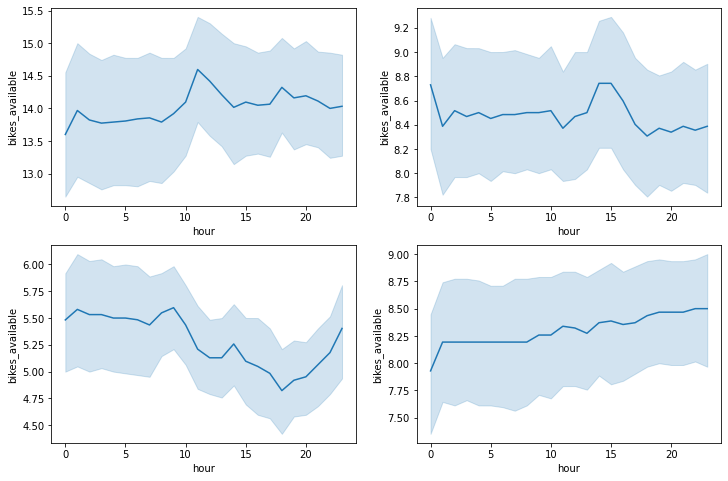

In [81]:
#bikes_availableの変動を可視化する
plt.figure(figsize=(12,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plot_df = status_df[(status_df["weekday"]=="土曜日")&(status_df["station_id"]==i)]
    sns.lineplot(x ='hour', y ='bikes_available',data = plot_df)

In [82]:
#これから細かい前処理をするためにmain_dfを作成
main_df = status_df[["date","month","hour","station_id","bikes_available","weekday","predict"]]
main_df.head()

,date,month,hour,station_id,bikes_available,weekday,predict
0,2013-09-01,9,0,0,11.0,日曜日,0
1,2013-09-01,9,1,0,11.0,日曜日,0
2,2013-09-01,9,2,0,11.0,日曜日,0
3,2013-09-01,9,3,0,11.0,日曜日,0
4,2013-09-01,9,4,0,11.0,日曜日,0


In [83]:
# hourをカテゴリ変数化するために、後々並べ替えように使うhour列を複製
hour_cat = pd.DataFrame(main_df['hour'].copy())
# hour_cat.columns = ['hour_cat']

hour_cat = hour_cat.rename({'hour' : 'hour_cat'}, axis=1)
hour_cat.head()

,hour_cat
0,0
1,1
2,2
3,3
4,4


In [84]:
hour_cat.astype({'hour_cat' : 'str'})
main_df = pd.concat([main_df, hour_cat['hour_cat']], axis=1)

In [85]:
#カテゴリ変数をダミー変数化
main_df = pd.get_dummies(main_df, columns=['month', 'weekday', 'hour_cat'])
print(main_df.head())
print(main_df.shape)

        date  hour  station_id  bikes_available  predict  month_1  month_2  \
0 2013-09-01     0           0             11.0        0        0        0   
1 2013-09-01     1           0             11.0        0        0        0   
2 2013-09-01     2           0             11.0        0        0        0   
3 2013-09-01     3           0             11.0        0        0        0   
4 2013-09-01     4           0             11.0        0        0        0   

   month_3  month_4  month_5  ...  hour_cat_14  hour_cat_15  hour_cat_16  \
0        0        0        0  ...            0            0            0   
1        0        0        0  ...            0            0            0   
2        0        0        0  ...            0            0            0   
3        0        0        0  ...            0            0            0   
4        0        0        0  ...            0            0            0   

   hour_cat_17  hour_cat_18  hour_cat_19  hour_cat_20  hour_cat_21  \
0   

In [87]:
# 新たな特徴量として、holidayを追加
import holidays

us_holidays = holidays.UnitedStates()
main_df['holiday'] = 0

for i in range(len(main_df)):
    if us_holidays.get(main_df['date'][i]):
        main_df['holiday'][i] = 1

In [88]:
main_df = pd.merge(main_df, station_df, on='station_id')

In [89]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1226400 entries, 0 to 1226399
Data columns (total 55 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   date               1226400 non-null  datetime64[ns]
 1   hour               1226400 non-null  int64         
 2   station_id         1226400 non-null  int64         
 3   bikes_available    809995 non-null   float64       
 4   predict            1226400 non-null  int64         
 5   month_1            1226400 non-null  uint8         
 6   month_2            1226400 non-null  uint8         
 7   month_3            1226400 non-null  uint8         
 8   month_4            1226400 non-null  uint8         
 9   month_5            1226400 non-null  uint8         
 10  month_6            1226400 non-null  uint8         
 11  month_7            1226400 non-null  uint8         
 12  month_8            1226400 non-null  uint8         
 13  month_9            1226400 

In [90]:
main_df['past_days'] = (main_df['date'] - pd.to_datetime(main_df['installation_date']))

In [91]:
for i, day in enumerate(main_df['past_days']):
    main_df['past_days'][i] = day.days
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [104]:
main_df = pd.get_dummies(main_df, columns=['city'])
print(main_df.head())

        date  hour  station_id  bikes_available  predict  month_1  month_2  \
0 2013-09-01     0           0             11.0        0        0        0   
1 2013-09-01     1           0             11.0        0        0        0   
2 2013-09-01     2           0             11.0        0        0        0   
3 2013-09-01     3           0             11.0        0        0        0   
4 2013-09-01     4           0             11.0        0        0        0   

   month_3  month_4  month_5  ...       long  dock_count  installation_date  \
0        0        0        0  ... -121.90178          27         2013-08-06   
1        0        0        0  ... -121.90178          27         2013-08-06   
2        0        0        0  ... -121.90178          27         2013-08-06   
3        0        0        0  ... -121.90178          27         2013-08-06   
4        0        0        0  ... -121.90178          27         2013-08-06   

   popu_density  past_days  city_city1  city_city2  city

In [105]:
main_df = main_df.drop(["lat", "long", "installation_date"],axis=1)
main_df.head()

,date,hour,station_id,bikes_available,predict,month_1,month_2,month_3,month_4,month_5,...,hour_cat_23,holiday,dock_count,popu_density,past_days,city_city1,city_city2,city_city3,city_city4,city_city5
0,2013-09-01,0,0,11.0,0,0,0,0,0,0,...,0,0,27,2200,26,1,0,0,0,0
1,2013-09-01,1,0,11.0,0,0,0,0,0,0,...,0,0,27,2200,26,1,0,0,0,0
2,2013-09-01,2,0,11.0,0,0,0,0,0,0,...,0,0,27,2200,26,1,0,0,0,0
3,2013-09-01,3,0,11.0,0,0,0,0,0,0,...,0,0,27,2200,26,1,0,0,0,0
4,2013-09-01,4,0,11.0,0,0,0,0,0,0,...,0,0,27,2200,26,1,0,0,0,0


In [4]:
for i , holiday in enumerate(main_df['holiday']):
    if holiday == 0:
        if main_df['weekday_土曜日'][i] == 1 or main_df['weekday_日曜日'][i] == 1:
            main_df['holiday'][i] = 1

In [10]:
#year, month, dayを結合してdatetime型に変換
leave_df["date"] = leave_df["s_year"].astype(str) + leave_df["s_month"].astype(str).str.zfill(2) + leave_df["s_day"].astype(str).str.zfill(2)
leave_df["date"] = pd.to_datetime(leave_df["date"])

arrive_df["date"] = arrive_df["e_year"].astype(str) + arrive_df["e_month"].astype(str).str.zfill(2) + arrive_df["e_day"].astype(str).str.zfill(2)
arrive_df["date"] = pd.to_datetime(arrive_df["date"])

leave_df = leave_df.sort_values(["date","s_hour","station_id"],ascending=True).reset_index(drop=True)
arrive_df = arrive_df.sort_values(["date","e_hour","station_id"],ascending=True).reset_index(drop=True)


In [11]:
arrive_df = arrive_df.drop(["Unnamed: 0"], axis=1)
leave_df = leave_df.drop(["Unnamed: 0"], axis=1)

leave_df = leave_df.rename(columns={'s_hour' : 'hour'})
arrive_df = arrive_df.rename(columns={'e_hour' : 'hour'})

In [12]:
leave_df.head(3360)

,station_id,s_year,s_month,s_day,hour,starts,date
0,0,2013,8,29,0,0,2013-08-29
1,1,2013,8,29,0,0,2013-08-29
2,2,2013,8,29,0,0,2013-08-29
3,3,2013,8,29,0,0,2013-08-29
4,4,2013,8,29,0,0,2013-08-29
...,...,...,...,...,...,...,...
3355,65,2013,8,30,23,0,2013-08-30
3356,66,2013,8,30,23,0,2013-08-30
3357,67,2013,8,30,23,0,2013-08-30
3358,68,2013,8,30,23,0,2013-08-30


In [13]:
arrive_df

,station_id,e_year,e_month,e_day,hour,ends,date
0,0,2013,8,29,0,0,2013-08-29
1,1,2013,8,29,0,0,2013-08-29
2,2,2013,8,29,0,0,2013-08-29
3,3,2013,8,29,0,0,2013-08-29
4,4,2013,8,29,0,0,2013-08-29
...,...,...,...,...,...,...,...
1231435,65,2015,8,31,23,0,2015-08-31
1231436,66,2015,8,31,23,0,2015-08-31
1231437,67,2015,8,31,23,0,2015-08-31
1231438,68,2015,8,31,23,0,2015-08-31


In [5]:
#学習用のデータフレームを作成
train_dataset_df = main_df[main_df["date"]<"2014-09-01"]
#評価用のデータフレームを作成(使用するモデルの関係上、前日のデータが必要なため2014-08-31から取得)
evaluation_dataset_df = main_df[main_df["date"]>="2014-08-31"]

In [6]:
#学習用データの欠損値を確認
print(train_dataset_df.isnull().sum())

date                   0
hour                   0
station_id             0
bikes_available    21605
predict                0
month_1                0
month_2                0
month_3                0
month_4                0
month_5                0
month_6                0
month_7                0
month_8                0
month_9                0
month_10               0
month_11               0
month_12               0
weekday_土曜日            0
weekday_日曜日            0
weekday_月曜日            0
weekday_木曜日            0
weekday_水曜日            0
weekday_火曜日            0
weekday_金曜日            0
hour_cat_0             0
hour_cat_1             0
hour_cat_2             0
hour_cat_3             0
hour_cat_4             0
hour_cat_5             0
hour_cat_6             0
hour_cat_7             0
hour_cat_8             0
hour_cat_9             0
hour_cat_10            0
hour_cat_11            0
hour_cat_12            0
hour_cat_13            0
hour_cat_14            0
hour_cat_15            0


In [7]:
train_dataset_df[train_dataset_df["bikes_available"].isnull()].head()

,date,hour,station_id,bikes_available,predict,month_1,month_2,month_3,month_4,month_5,...,hour_cat_23,holiday,dock_count,popu_density,past_days,city_city1,city_city2,city_city3,city_city4,city_city5
420480,2013-09-01,0,24,NaN,0,0,0,0,0,0,...,0,1,15,2263,-121,0,0,0,1,0
420481,2013-09-01,1,24,NaN,0,0,0,0,0,0,...,0,1,15,2263,-121,0,0,0,1,0
420482,2013-09-01,2,24,NaN,0,0,0,0,0,0,...,0,1,15,2263,-121,0,0,0,1,0
420483,2013-09-01,3,24,NaN,0,0,0,0,0,0,...,0,1,15,2263,-121,0,0,0,1,0
420484,2013-09-01,4,24,NaN,0,0,0,0,0,0,...,0,1,15,2263,-121,0,0,0,1,0


In [8]:
train_dataset_df[train_dataset_df["bikes_available"].isnull()].tail()

,date,hour,station_id,bikes_available,predict,month_1,month_2,month_3,month_4,month_5,...,hour_cat_23,holiday,dock_count,popu_density,past_days,city_city1,city_city2,city_city3,city_city4,city_city5
1214167,2014-04-09,7,69,NaN,0,0,0,0,1,0,...,0,0,15,2200,0,1,0,0,0,0
1214168,2014-04-09,8,69,NaN,0,0,0,0,1,0,...,0,0,15,2200,0,1,0,0,0,0
1214169,2014-04-09,9,69,NaN,0,0,0,0,1,0,...,0,0,15,2200,0,1,0,0,0,0
1214170,2014-04-09,10,69,NaN,0,0,0,0,1,0,...,0,0,15,2200,0,1,0,0,0,0
1214171,2014-04-09,11,69,NaN,0,0,0,0,1,0,...,0,0,15,2200,0,1,0,0,0,0


In [9]:
#各ステーション毎に、欠損値を後の値で埋める
train_dataset_df_new = pd.DataFrame()
for station_id in train_dataset_df["station_id"].unique().tolist():
    temp_df = train_dataset_df[train_dataset_df["station_id"]==station_id]
    temp_df = temp_df.fillna(method="bfill")
    train_dataset_df_new = pd.concat([train_dataset_df_new,temp_df])

print(train_dataset_df_new.isnull().sum())

date               0
hour               0
station_id         0
bikes_available    0
predict            0
month_1            0
month_2            0
month_3            0
month_4            0
month_5            0
month_6            0
month_7            0
month_8            0
month_9            0
month_10           0
month_11           0
month_12           0
weekday_土曜日        0
weekday_日曜日        0
weekday_月曜日        0
weekday_木曜日        0
weekday_水曜日        0
weekday_火曜日        0
weekday_金曜日        0
hour_cat_0         0
hour_cat_1         0
hour_cat_2         0
hour_cat_3         0
hour_cat_4         0
hour_cat_5         0
hour_cat_6         0
hour_cat_7         0
hour_cat_8         0
hour_cat_9         0
hour_cat_10        0
hour_cat_11        0
hour_cat_12        0
hour_cat_13        0
hour_cat_14        0
hour_cat_15        0
hour_cat_16        0
hour_cat_17        0
hour_cat_18        0
hour_cat_19        0
hour_cat_20        0
hour_cat_21        0
hour_cat_22        0
hour_cat_23  

In [10]:
temp_df#データセットを時系列に並び替える(後ほど説明)
c
evaluation_dataset_df = evaluation_dataset_df.sort_values(["date","hour","station_id"],ascending=True).reset_index(drop=True)
#学習用データセット
train_df.head()

,date,hour,station_id,bikes_available,predict,month_1,month_2,month_3,month_4,month_5,...,hour_cat_23,holiday,dock_count,popu_density,past_days,city_city1,city_city2,city_city3,city_city4,city_city5
0,2013-09-01,0,0,11.0,0,0,0,0,0,0,...,0,1,27,2200,26,1,0,0,0,0
1,2013-09-01,0,1,8.0,0,0,0,0,0,0,...,0,1,15,2200,27,1,0,0,0,0
2,2013-09-01,0,2,5.0,0,0,0,0,0,0,...,0,1,11,2200,26,1,0,0,0,0
3,2013-09-01,0,3,9.0,0,0,0,0,0,0,...,0,1,19,2200,27,1,0,0,0,0
4,2013-09-01,0,4,8.0,0,0,0,0,0,0,...,0,1,15,2200,25,1,0,0,0,0


In [11]:
#predictは特徴量として必要ないため、削除
train_df = train_df.drop(["predict"],axis=1)
train_df.head()

,date,hour,station_id,bikes_available,month_1,month_2,month_3,month_4,month_5,month_6,...,hour_cat_23,holiday,dock_count,popu_density,past_days,city_city1,city_city2,city_city3,city_city4,city_city5
0,2013-09-01,0,0,11.0,0,0,0,0,0,0,...,0,1,27,2200,26,1,0,0,0,0
1,2013-09-01,0,1,8.0,0,0,0,0,0,0,...,0,1,15,2200,27,1,0,0,0,0
2,2013-09-01,0,2,5.0,0,0,0,0,0,0,...,0,1,11,2200,26,1,0,0,0,0
3,2013-09-01,0,3,9.0,0,0,0,0,0,0,...,0,1,19,2200,27,1,0,0,0,0
4,2013-09-01,0,4,8.0,0,0,0,0,0,0,...,0,1,15,2200,25,1,0,0,0,0


In [12]:
train_df.shape

(613200, 56)

In [13]:
train_lstm = train_df.iloc[:, :-8]
train_dense = train_df.iloc[:, -8:]

In [14]:
train_lstm

,date,hour,station_id,bikes_available,month_1,month_2,month_3,month_4,month_5,month_6,...,hour_cat_15,hour_cat_16,hour_cat_17,hour_cat_18,hour_cat_19,hour_cat_20,hour_cat_21,hour_cat_22,hour_cat_23,holiday
0,2013-09-01,0,0,11.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2013-09-01,0,1,8.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2013-09-01,0,2,5.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2013-09-01,0,3,9.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2013-09-01,0,4,8.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613195,2014-08-31,23,65,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
613196,2014-08-31,23,66,9.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
613197,2014-08-31,23,67,7.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
613198,2014-08-31,23,68,8.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [15]:
#今回LSTMモデルを使用するため、データを標準化
#特徴量を標準化するための変数
scaler = MinMaxScaler(feature_range=(0, 1))
#標準化された出力をもとにスケールに変換(inverse)するために必要な変数
scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))
train_lstm_scale = scaler.fit_transform(train_lstm.iloc[:,3:])
train_dense_scale = scaler.fit_transform(train_dense)
bikes_available_scale = scaler_for_inverse.fit_transform(train_df[["bikes_available"]])

In [16]:
#学習用のデータをモデルの学習用とモデルの精度の検証用に分割
#今回は、モデル用学習データ:精度用の検証データ = 8 : 2 に分割
length = len(train_lstm_scale)
train_size = int(length * 0.8)
test_size = length - train_size
train_lstm, test_lstm = train_lstm_scale[0:train_size,:], train_lstm_scale[train_size:length,:]
train_dense, test_dense = train_dense_scale[0:train_size,:], train_dense_scale[train_size:length,:]
print(train_lstm.shape, train_dense.shape)
print(test_lstm.shape, test_dense.shape)

(490560, 45) (490560, 8)
(122640, 45) (122640, 8)


In [17]:
np.array(train_dense).shape

(490560, 8)

In [18]:
def create_lstm_dataset(dataset):
    dataX = []
    dataY = np.array([])
    #1680で1つのデータセットであるため、余りの分は使わない
    extra_num = len(dataset) % 70
    max_len = len(dataset)-extra_num
    for i in range(1680,max_len,70):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i-1680:i, j]
            xset.append(a)
        temp_array = np.array(dataset[i:i+70,0])
        dataY = np.concatenate([dataY,temp_array])
        dataX.append(xset)
    dataY = dataY.reshape(-1,70)
    return np.array(dataX), dataY

In [19]:
def create_dense_dataset(dataset):
    dataX = []
    #1680で1つのデータセットであるため、余りの分は使わない
    extra_num = len(dataset) % 70
    max_len = len(dataset)-extra_num
    for i in range(1680,max_len,70):
        xset = []
        for j in range(70):
            a = dataset[i+j, :]
            xset.extend(a)
        dataX.append(xset)
    return np.array(dataX)

In [20]:
trainX_lstm, trainY = create_lstm_dataset(train_lstm)
testX_lstm, testY = create_lstm_dataset(test_lstm)
#LSTMのモデルに入力用にデータの形を整形
trainX_lstm = np.reshape(trainX_lstm, (trainX_lstm.shape[0], trainX_lstm.shape[1], trainX_lstm.shape[2]))
testX_lstm = np.reshape(testX_lstm, (testX_lstm.shape[0], testX_lstm.shape[1], testX_lstm.shape[2]))
#入力データと正解データの形を確認
print(trainX_lstm.shape)
print(trainY.shape)

(6984, 45, 1680)
(6984, 70)


In [21]:
trainX_dense = np.array(create_dense_dataset(train_dense))
testX_dense = np.array(create_dense_dataset(test_dense))

In [22]:
trainX_dense = np.reshape(trainX_dense, (-1, 560, 1))

In [23]:
testX_dense = np.reshape(testX_dense, (-1, 560, 1))

In [24]:
early_stopping =  EarlyStopping(monitor='loss', min_delta=0.0, patience=2,)

input_lstm = Input(shape=(trainX_lstm.shape[1],1680))
input_dense = Input(shape=(trainX_dense.shape[1], 1))

station = Conv1D(1, 8, 8, activation='relu')(input_dense)
station = Flatten()(station)
station = Dense(units=30)(station)

bike = LSTM(50, input_shape=(trainX_lstm.shape[1],1680))(input_lstm)
bike = Dense(30, activation='relu')(bike)

ccat = concatenate([station, bike])
end_dense = Dense(units=30, activation='relu')(ccat)
end_dense = Dropout(0.5)(end_dense)
end_dense = Dense(70)(end_dense)

model = Model([input_lstm, input_dense], end_dense)

model.compile(loss='mean_squared_error', optimizer='adam')

2021-10-25 15:25:27.930533: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 560, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 70, 1)        9           input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 45, 1680)]   0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 70)           0           conv1d[0][0]                     
______________________________________________________________________________________________

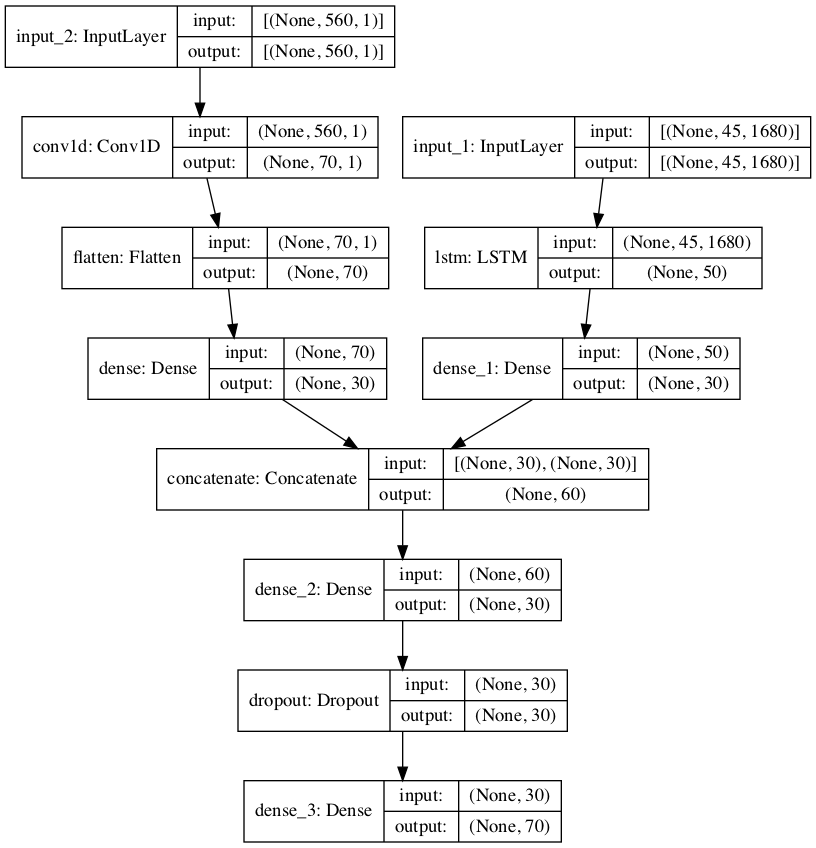

In [26]:
plot_model(
    model,
    show_shapes=True,
)

In [27]:
hist = model.fit([trainX_lstm,trainX_dense], trainY, epochs=20, batch_size=1, verbose=2, callbacks=[early_stopping])

2021-10-25 15:25:32.254229: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
6984/6984 - 62s - loss: 0.0150
Epoch 2/20
6984/6984 - 62s - loss: 0.0119
Epoch 3/20
6984/6984 - 62s - loss: 0.0119
Epoch 4/20
6984/6984 - 66s - loss: 0.0118
Epoch 5/20
6984/6984 - 67s - loss: 0.0118
Epoch 6/20
6984/6984 - 68s - loss: 0.0117
Epoch 7/20
6984/6984 - 67s - loss: 0.0117
Epoch 8/20
6984/6984 - 67s - loss: 0.0117
Epoch 9/20
6984/6984 - 68s - loss: 0.0117
Epoch 10/20
6984/6984 - 69s - loss: 0.0117
Epoch 11/20
6984/6984 - 68s - loss: 0.0116
Epoch 12/20
6984/6984 - 71s - loss: 0.0116
Epoch 13/20
6984/6984 - 71s - loss: 0.0117
Epoch 14/20
6984/6984 - 72s - loss: 0.0116


In [28]:
#学習済みモデルで予測
train_predict = model.predict([trainX_lstm, trainX_dense])
test_predict = model.predict([testX_lstm, testX_dense])

#スケールをもとに戻す
train_predict = scaler_for_inverse.inverse_transform(train_predict)
trainY = scaler_for_inverse.inverse_transform(trainY)
test_predict = scaler_for_inverse.inverse_transform(test_predict)
testY = scaler_for_inverse.inverse_transform(testY)

#各ステーションのスコアの平均値を算出
train_score_list = []
test_score_list = []
for i in range(70):
    trainscore = math.sqrt(mean_squared_error(trainY[:,i], train_predict[:,i]))
    train_score_list.append(trainscore)
    testscore = math.sqrt(mean_squared_error(testY[:,i], test_predict[:,i]))
    test_score_list.append(testscore)
    
print("trainのRMSE平均 : ",mean(train_score_list))
print("testのRMSE平均 : ",mean(test_score_list))

trainのRMSE平均 :  2.6484622784398537
testのRMSE平均 :  3.0700272902013555


In [29]:
#予測日とその前日を含むデータフレームを作成すると前日の日付データを返す関数
def make_sameday_thedaybefore_dataset(dataset,prediction_date):
    #前日の日付をtimedeltaで取得
    before_date = datetime.datetime.strptime(prediction_date, '%Y-%m-%d') - timedelta(days=1)
    prediction_date = str(prediction_date).split(" ")[0]
    before_date = str(before_date).split(" ")[0]
    #予測日とその前日を含むものだけを抽出
    temp_dataset = dataset[dataset["date"].isin([before_date,prediction_date])]
        
    return before_date,temp_dataset


#評価用のデータセットを作成する関数
def make_evaluation_dataset(dataset):
    output_df = pd.DataFrame()
    prediction_date_list = dataset[dataset["predict"]==1]["date"].tolist()
    for date in sorted(list(set(prediction_date_list))):
        before_date,temp_dataset = make_sameday_thedaybefore_dataset(dataset,date)
        #前日のbikes_availableに欠損値が含まれるかどうかの判定
        if temp_dataset[temp_dataset["date"]==before_date]["bikes_available"][1:].isnull().any(): 
            #各ステーションで予測日の０時で前日の1時以降のデータを置換
            #予測日のbikes_availableの置換は、後ほど別途処理するので今回は無視
            temp_dataset = temp_dataset.sort_values(["station_id","date","hour"]).fillna(method="bfill")
            temp_dataset = temp_dataset.sort_values(["date","hour","station_id"],ascending=True)
            #予測には、前日の1時からのデータしか使用しないので、0時のデータは除く
            output_df = pd.concat([output_df,temp_dataset.iloc[70:,:]])
        else: #欠損値なし　→ そのまま前日分のデータを利用
            output_df = pd.concat([output_df,temp_dataset.iloc[70:,:]])
        
    return output_df

In [30]:
evaluation_dataset_df.head()

,date,hour,station_id,bikes_available,predict,month_1,month_2,month_3,month_4,month_5,...,hour_cat_23,holiday,dock_count,popu_density,past_days,city_city1,city_city2,city_city3,city_city4,city_city5
0,2014-08-31,0,0,11.0,0,0,0,0,0,0,...,0,1,27,2200,390,1,0,0,0,0
1,2014-08-31,0,1,9.0,0,0,0,0,0,0,...,0,1,15,2200,391,1,0,0,0,0
2,2014-08-31,0,2,4.0,0,0,0,0,0,0,...,0,1,11,2200,390,1,0,0,0,0
3,2014-08-31,0,3,8.0,0,0,0,0,0,0,...,0,1,19,2200,391,1,0,0,0,0
4,2014-08-31,0,4,7.0,0,0,0,0,0,0,...,0,1,15,2200,389,1,0,0,0,0


In [31]:
evaluation_df = make_evaluation_dataset(evaluation_dataset_df)
evaluation_df.head()
# evaluation_df.tail()

,date,hour,station_id,bikes_available,predict,month_1,month_2,month_3,month_4,month_5,...,hour_cat_23,holiday,dock_count,popu_density,past_days,city_city1,city_city2,city_city3,city_city4,city_city5
70,2014-08-31,1,0,11.0,0,0,0,0,0,0,...,0,1,27,2200,390,1,0,0,0,0
71,2014-08-31,1,1,9.0,0,0,0,0,0,0,...,0,1,15,2200,391,1,0,0,0,0
72,2014-08-31,1,2,4.0,0,0,0,0,0,0,...,0,1,11,2200,390,1,0,0,0,0
73,2014-08-31,1,3,8.0,0,0,0,0,0,0,...,0,1,19,2200,391,1,0,0,0,0
74,2014-08-31,1,4,7.0,0,0,0,0,0,0,...,0,1,15,2200,389,1,0,0,0,0


In [32]:
#LSTMの出力結果でデータを補完しながら、提出用データフレームを作成する関数
def predict_eva_dataset(eva_dataset):
    submission_df = pd.DataFrame()
    #予測したbikes_availableを元のスケールに戻すための変数
    scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))
    scale_y = scaler_for_inverse.fit_transform(eva_dataset[["bikes_available"]])
    prediction_date_list = eva_dataset[eva_dataset["predict"]==1]["date"].tolist()
    for date in sorted(list(set(prediction_date_list))):
        before_date, temp_eva_dataset = make_sameday_thedaybefore_dataset(eva_dataset,date)
        for i in range(0,1610,70):
            #モデルに入れるためのデータセット(1680×columns)
            temp_eva_dataset_train = temp_eva_dataset.iloc[i:1680+i+70,:]
            #predictは特徴量に使わないため、ここで削除
            temp_eva_dataset_train = temp_eva_dataset_train.drop("predict",axis=1)
            #データを標準化する
            temp_eva_dataset_scale = scaler.fit_transform(temp_eva_dataset_train.iloc[:,3:])
            #モデルに入力する形にデータを整形
            train_lstm = []
            train_dense = []
            xset = []
            yset = []
            for j in range(45):
                a = temp_eva_dataset_scale[0:1680, j]
                xset.append(a)
            for j in range(70):
                b = temp_eva_dataset_scale[1680+j, 45:53]
                yset.extend(b)
            train_lstm.append(xset)
            train_lstm = np.array(train_lstm)
            train_lstm = np.reshape(train_lstm, (-1, 45, 1680))
            train_dense.append(yset)
            train_dense = np.array(train_dense)
            train_dense = np.reshape(train_dense, (-1, 560, 1))
            #学習済みlstmモデルで予測
            predict_scale = model.predict([train_lstm, train_dense])
            predict = scaler_for_inverse.inverse_transform(predict_scale)

            #次に使うbikes_availableに出力結果を補完
            temp_eva_dataset.iloc[1680+i:1750+i,3] = predict[0]
            #print(temp_eva_dataset[1680+i:1750+i])

        submission_df= pd.concat([submission_df,temp_eva_dataset.iloc[1610:,:]])
        
    return submission_df

In [33]:
evaluation_df

,date,hour,station_id,bikes_available,predict,month_1,month_2,month_3,month_4,month_5,...,hour_cat_23,holiday,dock_count,popu_density,past_days,city_city1,city_city2,city_city3,city_city4,city_city5
70,2014-08-31,1,0,11.0,0,0,0,0,0,0,...,0,1,27,2200,390,1,0,0,0,0
71,2014-08-31,1,1,9.0,0,0,0,0,0,0,...,0,1,15,2200,391,1,0,0,0,0
72,2014-08-31,1,2,4.0,0,0,0,0,0,0,...,0,1,11,2200,390,1,0,0,0,0
73,2014-08-31,1,3,8.0,0,0,0,0,0,0,...,0,1,19,2200,391,1,0,0,0,0
74,2014-08-31,1,4,7.0,0,0,0,0,0,0,...,0,1,15,2200,389,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611515,2015-08-29,23,65,NaN,1,0,0,0,0,0,...,1,1,27,7022,734,0,1,0,0,0
611516,2015-08-29,23,66,NaN,1,0,0,0,0,0,...,1,1,15,2200,606,1,0,0,0,0
611517,2015-08-29,23,67,NaN,1,0,0,0,0,0,...,1,1,15,7022,584,0,1,0,0,0
611518,2015-08-29,23,68,NaN,1,0,0,0,0,0,...,1,1,15,1494,555,0,0,1,0,0


<AxesSubplot:xlabel='date', ylabel='bikes_available'>

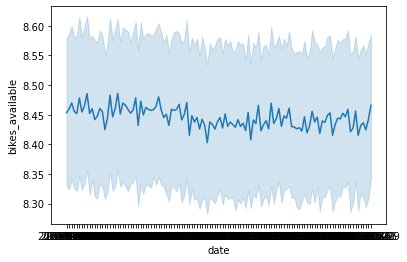

In [34]:
#予測した結果を時系列で可視化して確認
submission_df = predict_eva_dataset(evaluation_df)
sns.lineplot(x ='date', y ='bikes_available',data = submission_df)

In [40]:
submission_df

,date,hour,station_id,bikes_available,predict,month_1,month_2,month_3,month_4,month_5,...,hour_cat_23,holiday,dock_count,popu_density,past_days,city_city1,city_city2,city_city3,city_city4,city_city5
1680,2014-09-01,0,0,15.000000,0,0,0,0,0,0,...,0,1,27,2200,391,1,0,0,0,0
1681,2014-09-01,0,1,9.000000,0,0,0,0,0,0,...,0,1,15,2200,392,1,0,0,0,0
1682,2014-09-01,0,2,5.000000,0,0,0,0,0,0,...,0,1,11,2200,391,1,0,0,0,0
1683,2014-09-01,0,3,8.000000,0,0,0,0,0,0,...,0,1,19,2200,392,1,0,0,0,0
1684,2014-09-01,0,4,8.000000,0,0,0,0,0,0,...,0,1,15,2200,390,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611515,2015-08-29,23,65,13.234985,1,0,0,0,0,0,...,1,1,27,7022,734,0,1,0,0,0
611516,2015-08-29,23,66,6.910403,1,0,0,0,0,0,...,1,1,15,2200,606,1,0,0,0,0
611517,2015-08-29,23,67,4.512522,1,0,0,0,0,0,...,1,1,15,7022,584,0,1,0,0,0
611518,2015-08-29,23,68,3.203521,1,0,0,0,0,0,...,1,1,15,1494,555,0,0,1,0,0


In [36]:
submission_df['bikes_available'].value_counts()

6.000000     895
7.000000     871
8.000000     814
5.000000     771
9.000000     743
            ... 
11.849355      1
13.876117      1
11.422620      1
9.360620       1
0.541744       1
Name: bikes_available, Length: 5853, dtype: int64

In [37]:
lstm_submit_df = submission_df[submission_df["predict"]==1].sort_values(["station_id","date"])[["bikes_available"]]
lstm_submit_df["bikes_available"] = lstm_submit_df["bikes_available"].map(lambda x:0 if x < 0 else x)

In [38]:
lstm_submit_df.isnull().sum()

bikes_available    0
dtype: int64

In [39]:
lstm_submit_df.index = status_df[status_df["predict"]==1].index
lstm_submit_df.to_csv("lstm_submission.csv",header=None)#.head()